In [2]:
import eli5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from IPython.display import display
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [3]:
df = pd.read_csv("candy-data.csv", sep=',', encoding='ANSI')

In [4]:
df

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Twizzlers,0,1,0,0,0,0,0,0,0,0.220,0.116,45.466282
81,Warheads,0,1,0,0,0,0,1,0,0,0.093,0.116,39.011898
82,WelchÕs Fruit Snacks,0,1,0,0,0,0,0,0,1,0.313,0.313,44.375519
83,WertherÕs Original Caramel,0,0,1,0,0,0,1,0,0,0.186,0.267,41.904308


In [5]:
# split df into X and y and remove names (competitorname)
X = df.drop(columns=['winpercent', 'competitorname'], axis=1)
y = df['winpercent']

In [6]:
X

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent
0,1,0,1,0,0,1,0,1,0,0.732,0.860
1,1,0,0,0,1,0,0,1,0,0.604,0.511
2,0,0,0,0,0,0,0,0,0,0.011,0.116
3,0,0,0,0,0,0,0,0,0,0.011,0.511
4,0,1,0,0,0,0,0,0,0,0.906,0.511
...,...,...,...,...,...,...,...,...,...,...,...
80,0,1,0,0,0,0,0,0,0,0.220,0.116
81,0,1,0,0,0,0,1,0,0,0.093,0.116
82,0,1,0,0,0,0,0,0,1,0.313,0.313
83,0,0,1,0,0,0,1,0,0,0.186,0.267


In [7]:
y

0     66.971725
1     67.602936
2     32.261086
3     46.116505
4     52.341465
        ...    
80    45.466282
81    39.011898
82    44.375519
83    41.904308
84    49.524113
Name: winpercent, Length: 85, dtype: float64

In [8]:
# define a simple Ridge Regression Model and use Slope coefs to get a first impression of feature importance

In [9]:
# define the model and fit the model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [10]:
# Create dataframe from coefs
coefs = pd.DataFrame(
    model.coef_,
    columns=['Coefficients'], index=X.columns
)


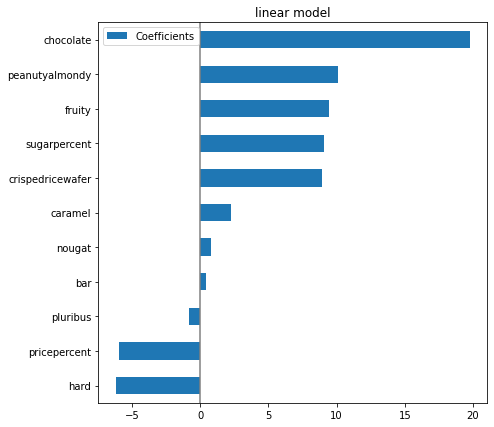

In [11]:
# Order and Plot Coefs 
coefs = coefs.sort_values(by=['Coefficients'])
coefs.plot(kind='barh', figsize=(9, 7))
plt.title('linear model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [12]:
# Since this problem might be of non-linear nature 
# let's try a Random Forest model and use SHAP
# and permutation importance from eli5

In [13]:
model = RandomForestRegressor()
model.fit(X, y)

RandomForestRegressor()

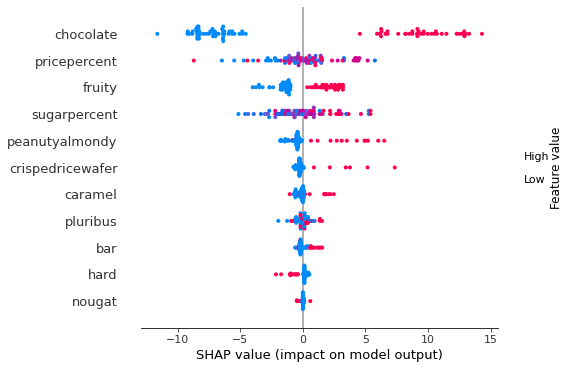

In [14]:
# compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values, max_display=13)

BLUE means that the feature value was low and RED means that it was HIGH
this means (Only considering shap values):
- chocolate seems to increase the popularity the most
- fruity seems to behave like chocolate but to a lesser extent
- a lower price generally leads to a higher popularity
- peanutyalmondy seems to increase popularity
- a higher sugarpercent seems to increase popularity
- crispedricewafer mostly seems to increase popularity and almost never leads to a lower popularity
- hard candy has a low impact generally but is likely to decrease the popularity
- bar tends to very slightly increase popularity
- nougat, caramel, pluribus has almost no effect



In [15]:
perm = PermutationImportance(model).fit(X, y)
display(eli5.show_weights(perm, feature_names=X.columns.tolist()))

Weight,Feature
0.9888 ± 0.1301,chocolate
0.2135 ± 0.0359,sugarpercent
0.2110 ± 0.0259,pricepercent
0.1136 ± 0.0409,fruity
0.1072 ± 0.0180,peanutyalmondy
0.0488 ± 0.0296,crispedricewafer
0.0357 ± 0.0105,pluribus
0.0295 ± 0.0123,caramel
0.0252 ± 0.0060,bar
0.0139 ± 0.0101,hard


<AxesSubplot:>

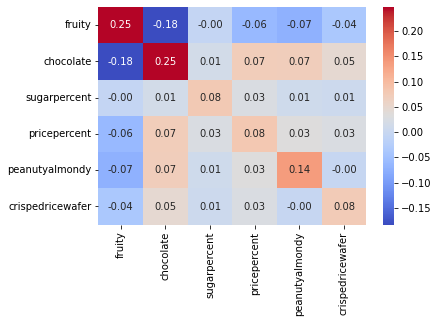

In [18]:
#Check Covariance of previous top features to realize if we our candy should both be fruity and chocolate (would be unexpected)
data = np.array([X['fruity'].tolist(), X['chocolate'].tolist(), X['sugarpercent'].tolist(), X['pricepercent'].tolist(),
                 X['peanutyalmondy'].tolist(), X['crispedricewafer'].tolist()])
label = ['fruity', 'chocolate', 'sugarpercent', 'pricepercent', 'peanutyalmondy', 'crispedricewafer']

covMatrix = np.cov(data, bias=True)
sns.heatmap(covMatrix, label=label, annot=True, fmt='.2f', xticklabels=label, yticklabels=label, cmap='coolwarm')


highest negative covariance between fruity and chocolate :-> Products should most likely be either one and not both
pricepercent and chocolate have higher covariance than fruity and pricepercent -> When products are made from chocolate, they also allow for a higher price
peanutyalmondy and chocolate have a high covariance :-> products that contain chocolate most often are also peanutyalmondy
sugarpercent has almost no impact on other "top" features
crispedricewafer has a postive covariance with chocolate but not with peanutyalmondy



<AxesSubplot:>

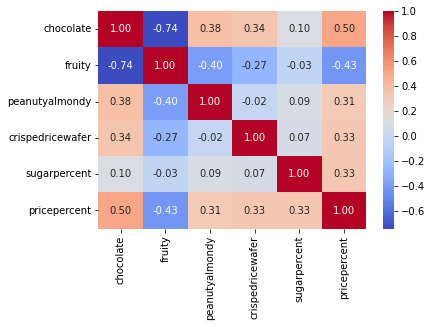

In [23]:

corrMatrix = X.drop(columns=['nougat','hard','pluribus','bar','caramel']).corr()
sns.heatmap(corrMatrix, annot=True, fmt='.2f', cmap='coolwarm')


As a result the product:
- Should be made from chocolate and NOT be fruity
- Should be containing a relative high amount of sugar when compared with the products in the given list
- It should contain peanuts or almonds, since that seems to be a good addition to a chocolate product
- Crispedricewafer also goes well with chocolate, but it should most likely be a decision between peanuts/almonds or Crispedricewafer
- A higher price will most likely lower the popularity of the product :-> Management decision
- the Product should be a bar
- Adding caramel or nougat to the product is most likely not going to increase popularity and there can be dismissed or optional, and should be based of the price for them compared to chocolate. A product could be containing these if they are cheaper than chocolate.